### 导包

In [1]:
import torch
import torch.nn as nn
import numpy as np
#from pyDOE import lhs
import matplotlib.pyplot as plt
import os
import scipy.io
from scipy.interpolate import griddata
from collections import OrderedDict

### 随机种子

In [2]:
def seed_torch(seed=1024):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
#     torch.use_deterministic_algorithms(True)  # 有检查操作，看下文区别
 
seed_torch(314)

#### 计时器

In [3]:
import time
class Timer:
    ###构建一个timer的列表进行计算
    
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    ## 开始计时
    def start(self):
        """Start the timer."""
        self.tik = time.time()

    ##将计时的结果加入到储存时间表中
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    ## 求平均时间
    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    ## 求总时间
    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()
    

In [4]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#### 辅助函数

In [5]:
#计算梯度
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)

#转化为numpy
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

### 网络(标准化optional）

In [6]:
class ModifiedMLP(nn.Module):
    def __init__(self, mlp_layers, is_regularization = False):
        super(ModifiedMLP, self).__init__()
        
        self.is_regularization = is_regularization
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
        for param in self.parameters():
            if len(param.shape) > 1:
                #kaiming初始化
                nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        
        if self.is_regularization == True:
            mu = X.mean(dim = 0)
            sigma = X.std(dim = 0)
            X = (X - mu) / sigma
            
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        for i in range(len(self.model) - 1):
            X = self.model[i](X)
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)
    
    
# backbone = ModifiedMLP(backbone_layers)
# nn_lam = ModifiedMLP(nn_lam_layers)

### PINN_net

In [7]:
class PINN_net(nn.Module):
    def __init__(self, net_layers, lambda_layers, is_regularization = False):
        super(PINN_net, self).__init__()
        
        self.is_regularization = is_regularization
        self.sigma_x = 1.
        self.sigma_t = 1.
        
        #network
        self.dnn = ModifiedMLP(net_layers, is_regularization=is_regularization).to(device)
        self.lambda_dnn = ModifiedMLP(lambda_layers, is_regularization=is_regularization).to(device)
        
    def net_lam(self, t):
        lambda_1 = self.lambda_dnn(t)
        return lambda_1
        
    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t] ,dim=1))
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        if self.is_regularization == True:
            self.sigma_x = torch.std(x)
            self.sigma_t = torch.std(t)
        u_t = gradients(u, t)[0] / self.sigma_t
        u_x = gradients(u, x)[0] / self.sigma_x

        u_xx = gradients(u_x, x)[0] / self.sigma_x
        u_tt = gradients(u_t, t)[0] / self.sigma_t
        
        lambda_1 = self.net_lam(t)
        
        return u_tt - lambda_1 * u_xx + torch.sin(u)
    
    def net_data(self, x_data, t_data, u_data):
        u_pred_data = self.net_u(x_data, t_data)
#         print(f"u_pred_data.shape:{u_pred_data.shape}")
#         print(f"u_data.shape:{u_data.shape}")
        return u_pred_data - u_data
    
    def forward(self, x, t, x_data, t_data, u_data):
        loss_res = torch.mean(self.net_f(x, t)**2)
        loss_data = torch.mean(self.net_data(x_data, t_data, u_data)**2)
        return loss_res, loss_data   

#### SG方程样例

$$\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} -sin (u)$$

### 数据集生成和超参数

In [8]:
def true_solution(x, t):
    return 4 * np.arctan(np.sin(t/np.sqrt(2))/np.cosh(x/np.sqrt(2)))

In [9]:
#boudary
# t-->(0, 20)
# x-->(-20, 20)

#采样点
N_f_x = 256 
N_f_t = 256

N_f = 2000
N_0 = 200
N_data = 3000

#boundary
lb = np.array([-20, 0])
ub = np.array([20, 20])
#residual point
#X = lb + (ub - lb) * lhs(2, N_f)
x = np.linspace(lb[0], ub[0], N_f_x).reshape(-1, 1)
t = np.linspace(lb[1], ub[1], N_f_t).reshape(-1, 1)
xx, tt = np.meshgrid(x, t)

X = np.concatenate([xx.reshape(-1, 1), tt.reshape(-1, 1)], axis=1)
idx = np.random.permutation(range(X.shape[0]))
idx = idx[: N_f]  
X = X[idx, :]
u = true_solution(xx, tt)

#initial point(None_use)
x0 = np.linspace(lb[0], ub[0], N_f).reshape(-1, 1)
t0 = np.ones_like(x0)
X0 = np.hstack([x0, t0])

#data point
x_data = lb[0] + np.random.rand(N_data, 1) * (ub[0] - lb[0])
t_data = lb[1] + np.random.rand(N_data, 1) * (ub[1] - lb[1])
X_data = np.hstack([x_data, t_data])
u_data = true_solution(x_data, t_data)


#layers
net_layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
lambda_layers = [1, 20, 1]

#lr
adam_net_lr = 1e-3 
adam_lambda_lr = 1e-3
lbfgs_lr = 1.

#epoch
epoch_Adam = 5000
epoch_lbfgs = 10000

#save_path
save_path_Adam = "SG-identification_Adam"
save_path_Adam_lbfgs = "SG-identification_Adam_lbfgs"

#### point_todevice 
#res
x = torch.tensor(X[:, 0: 1], requires_grad=True).float().to(device)
t = torch.tensor(X[:, 1: 2], requires_grad=True).float().to(device)

#ic
# x0 = torch.tensor(X0[:, 0: 1], requires_grad=True).float().to(device)
# t0 = torch.tensor(X0[:, 1: 2], requires_grad=True).float().to(device)

#data
x_data = torch.tensor(X_data[:, 0: 1]).float().to(device)
t_data = torch.tensor(X_data[:, 1: 2]).float().to(device)
u_data = torch.tensor(u_data).float().to(device)

In [10]:
X.shape, X_data.shape,u_data.shape, x.shape, t.shape, x_data.shape, t_data.shape, u_data.shape

((2000, 2),
 (3000, 2),
 torch.Size([3000, 1]),
 torch.Size([2000, 1]),
 torch.Size([2000, 1]),
 torch.Size([3000, 1]),
 torch.Size([3000, 1]),
 torch.Size([3000, 1]))

### visualize

#### res_point without sample

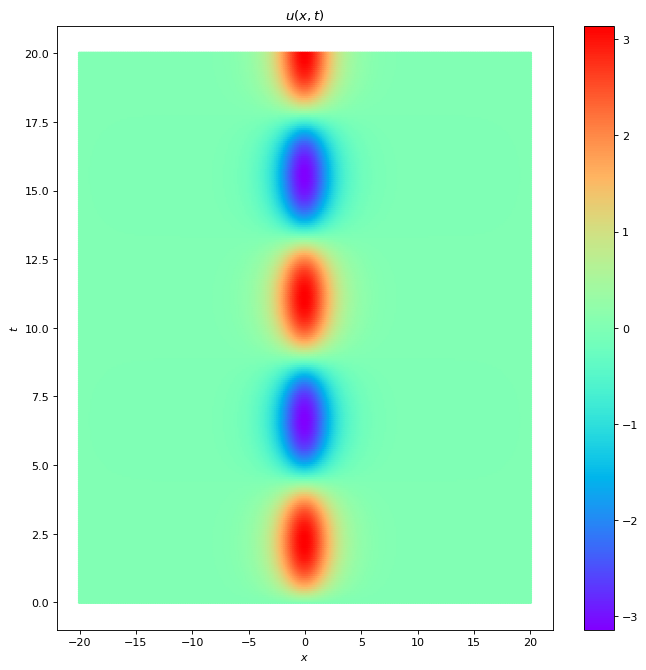

In [11]:
fig = plt.figure(figsize=(10, 10), dpi = 80)
plt.scatter(xx, tt, c = u, s = 4, cmap="rainbow")
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.title("$u(x, t)$")
plt.show()

#### data_point

In [12]:
# fig = plt.figure(figsize=(10, 10), dpi = 80)
# plt.scatter(to_numpy(x_data), to_numpy(t_data), c = u_data, s = 5, cmap="jet")
# plt.colorbar()
# plt.xlabel("$x$")
# plt.ylabel("$t$")
# plt.title("$u(x, t)$")
# plt.show()

### PINN && Adam

In [13]:
pinn_sg = PINN_net(net_layers, lambda_layers, is_regularization = True)

optimizer_adam = torch.optim.Adam(pinn_sg.dnn.parameters(), lr=1e-3)
optimizer_adam_lam = torch.optim.Adam(pinn_sg.lambda_dnn.parameters(), lr=1e-3)

# 指数衰减学习率
lr_sche = torch.optim.lr_scheduler.ExponentialLR(optimizer_adam, gamma=0.8) 
lr_sche_lam = torch.optim.lr_scheduler.ExponentialLR(optimizer_adam_lam, gamma=0.9)

#Adam_loss_history
loss_his_Adam = {"epoch":[], "loss":[], "loss_res":[], "loss_data":[]}


### lbfgs

In [14]:
# #pinn_sg = PINN_net(net_layers, lambda_layers)

# optimizer_lbfgs = torch.optim.LBFGS(
#         pinn_sg.dnn.parameters(), 
#         lr=lbfgs_lr, 
#         max_iter=50000, 
#         max_eval=50000, 
#         history_size=50,
#         tolerance_grad=1e-5, 
#         tolerance_change=1.0 * np.finfo(float).eps,
#         line_search_fn="strong_wolfe")       # can be "strong_wolfe" 

# optimizer_adam_lam = torch.optim.Adam(pinn_sg.lambda_dnn.parameters(), lr=1e-3)

# #lbfgs_loss_history
# loss_his_Adam = {"epoch":[], "loss":[], "loss_res":[], "loss_data":[]}

### 训练

#### with_adam

In [15]:
timer1 = Timer()
best_loss = 1e5

for epoch in range(epoch_Adam):
    pinn_sg.train() 
    pinn_sg.zero_grad()
    
    loss_res, loss_data = pinn_sg(x, t, x_data, t_data, u_data)
    loss = 100 * loss_data + 100 * loss_res
    
    loss.backward()
    
    #optimzers
    optimizer_adam.step()
    optimizer_adam_lam.step()

    if epoch % 500 == 0:
        print(
            '###Adam_iter: %d/100000, Loss: %e, loss_res: %.3e, loss_data: %.3e, ---time: %d' % 
            (
                epoch,
                loss.item(), 
                loss_res.item(),
                loss_data.item(),
                timer1.stop()
            )
             )

        loss_his_Adam["epoch"].append(epoch)
        loss_his_Adam["loss"].append(loss.item())
        loss_his_Adam["loss_res"].append(loss_res.item())
        loss_his_Adam["loss_data"].append(loss_data.item())

    if best_loss > loss:
        model_state = {'epoch': epoch, 'net_state': pinn_sg.dnn.state_dict(), 'net_lam_state': pinn_sg.lambda_dnn.state_dict()}
        torch.save(model_state, save_path_Adam)
        best_loss = loss.item()
    
    if (epoch + 1) % 2000 == 0:
        lr_sche.step()
        lr_sche_lam.step()

###Adam_iter: 0/100000, Loss: 1.286224e+02, loss_res: 2.652e-01, loss_data: 1.021e+00, ---time: 0
###Adam_iter: 500/100000, Loss: 2.384796e+01, loss_res: 6.604e-02, loss_data: 1.724e-01, ---time: 62
###Adam_iter: 1000/100000, Loss: 8.162575e+00, loss_res: 5.799e-02, loss_data: 2.364e-02, ---time: 126
###Adam_iter: 1500/100000, Loss: 5.586292e+00, loss_res: 3.560e-02, loss_data: 2.026e-02, ---time: 188
###Adam_iter: 2000/100000, Loss: 4.927541e+00, loss_res: 2.953e-02, loss_data: 1.975e-02, ---time: 246
###Adam_iter: 2500/100000, Loss: 4.486773e+00, loss_res: 2.575e-02, loss_data: 1.912e-02, ---time: 303
###Adam_iter: 3000/100000, Loss: 4.112298e+00, loss_res: 2.320e-02, loss_data: 1.792e-02, ---time: 365
###Adam_iter: 3500/100000, Loss: 3.722387e+00, loss_res: 2.121e-02, loss_data: 1.601e-02, ---time: 427
###Adam_iter: 4000/100000, Loss: 3.346650e+00, loss_res: 1.901e-02, loss_data: 1.446e-02, ---time: 492
###Adam_iter: 4500/100000, Loss: 3.035720e+00, loss_res: 1.712e-02, loss_data: 1

#### with_lbfgs

In [16]:
# time.sleep(1)
# timer2 = Timer()

# for epoch in range(epoch_lbfgs):
#     def closure():
        
#         pinn_sg.train() 
#         pinn_sg.zero_grad()

#         loss_res, loss_data = pinn_sg(x, t, x_data, t_data, u_data)
#         loss = 100 * loss_data + 100 * loss_res

#         loss.backward()
        
#         return loss
    
#     #optimzers
#     optimizer_lbfgs.step(closure)
#     optimizer_adam_lam.step()

#     if epoch % 500 == 0:
#         pinn_sg.train(False)
#         loss_res, loss_data = pinn_sg(x, t, x_data, t_data, u_data)
#         loss = loss_data + loss_res
#         print(
#             '###Adam_iter: %d/40000, Loss: %e, loss_res: %.3e, loss_data: %.3e, ---time: %d' % 
#             (
#                 epoch,
#                 loss.item(), 
#                 loss_res.item(),
#                 loss_data.item(),
#                 timer2.stop()
#             )
#              )

#         loss_his_lbfgs["epoch"].append(epoch)
#         loss_his_lbfgs["loss"].append(loss.item())
#         loss_his_lbfgs["loss_res"].append(loss_res.item())
#         loss_his_lbfgs["loss_data"].append(loss_data.item())

#     if best_loss > loss:
#         model_state = {'epoch': epoch, 'net_state': pinn_sg.dnn.state_dict(), 'net_lam_state': pinn_sg.lambda_dnn.state_dict()}
#         torch.save(model_state, save_path_lbfgs)
#         best_loss = loss.item()
    

### save

In [17]:
# np.save("loss_his_adam.npy", loss_his_Adam)

### load

In [18]:
# loss_his_Adam = np.load("loss_his_adam.npy", allow_pickle=True).item()
# model_state = torch.load("SG-identification_Adam")
# pinn_sg.dnn.load_state_dict(model_state['net_state'])
# pinn_sg.lambda_dnn.load_state_dict(model_state['net_lam_state'])
# #进入评估模式
# pinn_sg.eval()

### L2_error

In [19]:
#boundary
lb = np.array([-20, 0])
ub = np.array([20, 20])
#test_point
x = np.linspace(lb[0], ub[0], 100).reshape(-1, 1)
t = np.linspace(lb[1], ub[1], 256).reshape(-1, 1)
xx, tt = np.meshgrid(x, t)
usol = true_solution(xx, tt)

X_star = np.hstack((xx.flatten()[:,None], tt.flatten()[:,None]))
X_star = torch.tensor(X_star).double()
u_star = usol.flatten()[:, None]

pinn_sg = pinn_sg.cpu().double()
u_pred = pinn_sg.net_u(X_star[:, 0:1], X_star[:, 1:2]).detach().numpy()
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print("error_u: %.5e" % (error_u))
# lambda_1_value = model.lambda_1.detach().cpu().numpy()
# error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
# print("Error lambda:%.5f%%" % (error_lambda_1))

t = np.linspace(lb[1], ub[1], 256).reshape(-1, 1)
t_tensor = torch.tensor(t).double()
lambda_pred = pinn_sg.lambda_dnn(t_tensor).detach().numpy()
lambda_star = np.ones_like(lambda_pred)
lambda_error = np.linalg.norm(lambda_pred - lambda_star) / np.linalg.norm(lambda_star)
print('Relative l2 error of lambda: {:.3e}'.format(lambda_error))

error_u: 3.56314e-01
Relative l2 error of lambda: 2.743e+01


### predict visualize

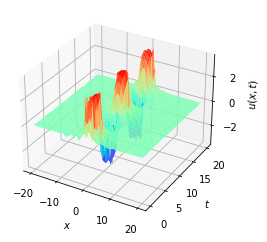

In [20]:
U_pred = griddata(X_star, u_pred.flatten(), (xx, tt), method='cubic')

fig = plt.figure()  
ax = plt.axes(projection='3d')

#作图
ax.plot_surface(xx, tt, U_pred,cmap='rainbow')
#ax3.contour(X,Y,Z, zdim='z',offset=-2，cmap='rainbow)   
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$u(x, t)$")
plt.show()

####  pred

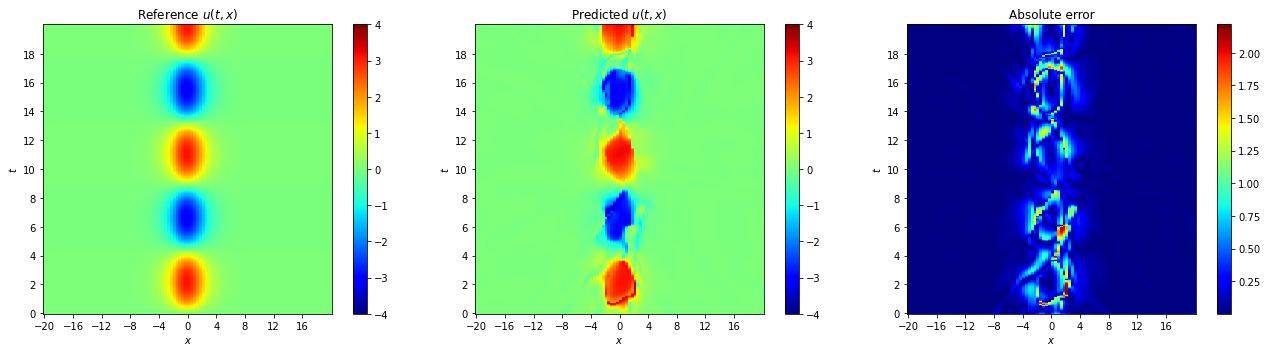

In [21]:
fig = plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 3, 1)
plt.pcolor(xx, tt, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')  # 设置坐标轴标签
plt.ylabel('$t$')
plt.xticks(np.arange(-20, 20, 4.))  # 设置坐标轴刻度
plt.yticks(np.arange(0, 20, 2.))
plt.clim([-4, 4])
plt.title(r'Reference $u(t,x)$')
plt.tight_layout()
ax1.set_aspect(1./ax1.get_data_ratio())  # 使每个子图是正方形

ax2 = plt.subplot(1, 3, 2)
plt.pcolor(xx, tt, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.xticks(np.arange(-20, 20, 4.))  # 设置坐标轴刻度
plt.yticks(np.arange(0, 20, 2.))
plt.clim([-4, 4])
plt.title(r'Predicted $u(t,x)$')
plt.tight_layout()
ax2.set_aspect(1./ax1.get_data_ratio())

ax3 = plt.subplot(1, 3, 3)
plt.pcolor(xx, tt, np.abs(usol - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.xticks(np.arange(-20, 20, 4.))  # 设置坐标轴刻度
plt.yticks(np.arange(0, 20, 2.))
plt.title('Absolute error')
plt.tight_layout()
ax3.set_aspect(1./ax1.get_data_ratio())

plt.savefig('SG_result.png', dpi=100, bbox_inches='tight')
plt.show()

### loss

#### Adam

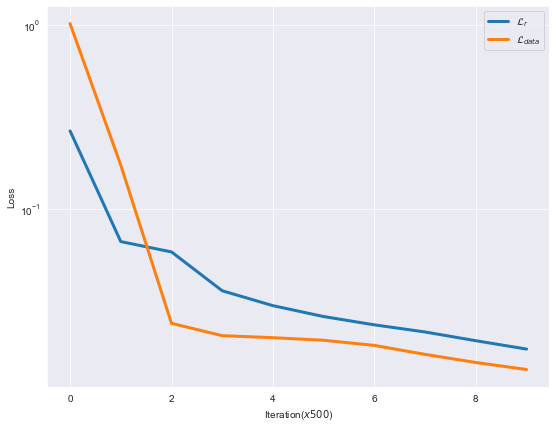

In [22]:
import seaborn as sns
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(9, 7))
    plt.subplot(111)
    # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
    plt.plot(loss_his_Adam["loss_res"], label=r"$\mathcal{L}_{r}$", linewidth=3)
    plt.plot(loss_his_Adam["loss_data"], label=r"$\mathcal{L}_{data}$", linewidth=3)
    plt.legend()
    #plt.xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000])
    plt.xlabel('Iteration($x500$)')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig('loss.png', dpi=100)
    plt.show()

#### lbfgs

In [23]:
# with sns.axes_style("darkgrid"):
#     plt.figure(figsize=(9, 7))
#     plt.subplot(111)
#     # plt.plot(logger["iter"][::k], logger["loss"][::k], label=r"$L$")
#     plt.plot(loss_his_lbfgs["epoch"], model.loss_his_lbfgs["loss_res"], label=r"$\mathcal{L}_{r}$", linewidth=3)
#     plt.plot(loss_his_lbfgs["epoch"], model.loss_his_lbfgs["loss_data"], label=r"$\mathcal{L}_{data}$", linewidth=3)
#     plt.legend()
#     plt.xticks([0, 2000, 4000, 6000, 8000, 10000])
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.yscale('log')
#     plt.savefig('loss.png', dpi=100)
#     plt.show()

### 观察net_lambda预测出的值与预测的值

In [24]:
t = np.linspace(lb[1], ub[1], 256).reshape(-1, 1)
t_tensor = torch.tensor(t).double()
lambda_pred = pinn_sg.lambda_dnn(t_tensor).detach().numpy()
lambda_pred

array([[ 18.58429385],
       [ 18.60612937],
       [ 18.62673417],
       [ 18.64606631],
       [ 18.66408292],
       [ 18.68074019],
       [ 18.69599337],
       [ 18.70979678],
       [ 18.72210378],
       [ 18.73286675],
       [ 18.74203716],
       [ 18.74956549],
       [ 18.75540126],
       [ 18.75949303],
       [ 18.7617884 ],
       [ 18.76223402],
       [ 18.76077556],
       [ 18.75735774],
       [ 18.75192434],
       [ 18.74441819],
       [ 18.73478117],
       [ 18.72295423],
       [ 18.70887742],
       [ 18.69248984],
       [ 18.6737297 ],
       [ 18.65253434],
       [ 18.62884019],
       [ 18.60258285],
       [ 18.57369705],
       [ 18.54211671],
       [ 18.50777493],
       [ 18.47060404],
       [ 18.43053559],
       [ 18.38750041],
       [ 18.34142862],
       [ 18.29224965],
       [ 18.23989229],
       [ 18.1842847 ],
       [ 18.12535449],
       [ 18.06302871],
       [ 17.99723392],
       [ 17.92789621],
       [ 17.85494129],
       [ 17

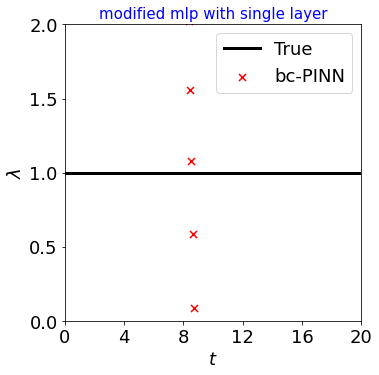

In [25]:
plt.rcParams.update({'font.size':18})

fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 2, 2)
lambda_true = np.ones_like(t)
ax.plot(t, lambda_true, linewidth=3, color='black', label="True")
ax.scatter(t[::1], lambda_pred[::1], marker='x', s=50, color='red', label='bc-PINN')
# ax.plot(t, lam2_pred, linewidth=3, linestyle='--', color='blue', label='cS-PINN')
#ax.scatter(t[::10], lambda_pred[::10], marker='^', s=100, color='blue', label='Residuals-RAE')
ax.set_xlim([0, 10])
ax.set_xticks(np.arange(0, 20.1, 4))
ax.set_xlabel('$t$')
ax.set_ylim([0, 2])
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_ylabel('$\lambda$')
ax.set_title("modified mlp with single layer", fontdict={"size":15, "color":"b"})
plt.legend(loc='upper right')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

# plt.savefig('SG.png', dpi=100, bbox_inches='tight')
plt.show()

In [26]:
1、subnet用dnn


SyntaxError: invalid character in identifier (<ipython-input-26-232d1ad7583e>, line 1)